In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
from copy import deepcopy

import blobfile as bf
import torch
from cupbearer import data, detectors, models, scripts, tasks, utils
from IPython.display import Markdown, display
from torch import nn
from torch.utils.data import Subset
from transformer_lens import HookedTransformer

In [3]:
task = tasks.tiny_natural_mechanisms("hex", "mps")

Loaded pretrained model attn-only-1l into HookedTransformer
Moving model to device:  mps


In [4]:
def get_activation_at_last_token(
    activation: torch.Tensor, inputs: list[list[int]], name: str
):
    if activation.ndim == 3:
        # Residual stream or equivalent, shape is (batch, seq, hidden)
        return activation[:, -1, :]
    elif activation.ndim == 4 and activation.shape[-1] == activation.shape[-2]:
        # Attention, shape is (batch, num_heads, query, key)
        # TODO: this could also be Q/K/V if n_heads happens to be head_dim
        return activation[:, :, -1, :].reshape(activation.shape[0], -1)
    elif activation.ndim == 4:
        # Query/key/value, shape is (batch, seq, num_heads, hidden)
        return activation[:, -1, :, :].reshape(activation.shape[0], -1)
    else:
        raise ValueError(f"Unexpected activation shape: {activation.shape}")

In [5]:
names = [
    "hook_embed.output",
    # "blocks.0.hook_attn_out.output",
    # "blocks.0.attn.hook_attn_scores.output",
    # "blocks.0.attn.hook_q.output",
    # "ln_final.hook_normalized.output",
]

detector = detectors.MahalanobisDetector(names, layer_aggregation="mean")

In [6]:
for name, _ in task.model.named_modules():
    print(name)


embed
hook_embed
pos_embed
hook_pos_embed
blocks
blocks.0
blocks.0.ln1
blocks.0.ln1.hook_scale
blocks.0.ln1.hook_normalized
blocks.0.attn
blocks.0.attn.hook_k
blocks.0.attn.hook_q
blocks.0.attn.hook_v
blocks.0.attn.hook_z
blocks.0.attn.hook_attn_scores
blocks.0.attn.hook_pattern
blocks.0.attn.hook_result
blocks.0.hook_attn_in
blocks.0.hook_q_input
blocks.0.hook_k_input
blocks.0.hook_v_input
blocks.0.hook_mlp_in
blocks.0.hook_attn_out
blocks.0.hook_mlp_out
blocks.0.hook_resid_pre
blocks.0.hook_resid_post
ln_final
ln_final.hook_scale
ln_final.hook_normalized
unembed


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|██████████| 256/256 [00:01<00:00, 134.76it/s]


Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

2024-05-25 22:22:13.240 | INFO     | cupbearer.detectors.anomaly_detector:eval:152 - AUC_ROC (all): 0.7204
2024-05-25 22:22:13.240 | INFO     | cupbearer.detectors.anomaly_detector:eval:153 - AP (all): 0.6272


(defaultdict(dict,
             {'all': {'AUC_ROC': 0.7204084396362305,
               'AP': 0.6271838366488258}}),
 {'all': <Figure size 640x480 with 1 Axes>})

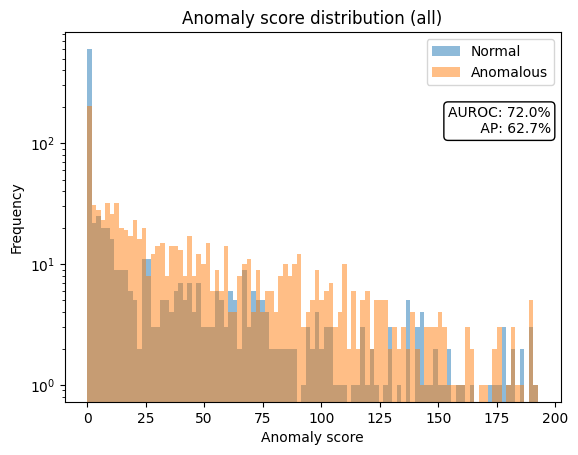

In [7]:
scripts.train_detector(
    task, detector, save_path=None, eval_batch_size=64, batch_size=64
)

# Supervised skyline

In [8]:
n_train = 512
clean_train_data = Subset(task.test_data.normal_data, range(n_train))
clean_test_data = Subset(task.test_data.normal_data, range(n_train, 1024))
anomalous_train_data = Subset(task.test_data.anomalous_data, range(n_train))
anomalous_test_data = Subset(task.test_data.anomalous_data, range(n_train, 1024))

supervised_task = tasks.Task.from_separate_data(
    model=task.model,
    trusted_data=task.trusted_data,
    clean_test_data=clean_test_data,
    anomalous_test_data=anomalous_test_data,
    clean_untrusted_data=clean_train_data,
    anomalous_untrusted_data=anomalous_train_data,
    untrusted_labels=True,
)

In [9]:
names = [
    "blocks.0.hook_attn_out.output",
    "blocks.0.attn.hook_attn_scores.output",
    "blocks.0.attn.hook_q.output",
    "ln_final.hook_normalized.output",
]
detector = detectors.SupervisedLinearProbe([names[0]], get_activation_at_last_token)

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

2024-05-25 22:22:28.557 | INFO     | cupbearer.detectors.anomaly_detector:eval:152 - AUC_ROC (all): 0.9995
2024-05-25 22:22:28.559 | INFO     | cupbearer.detectors.anomaly_detector:eval:153 - AP (all): 0.9995


(defaultdict(dict,
             {'all': {'AUC_ROC': 0.9995498657226562,
               'AP': 0.999538515911175}}),
 {'all': <Figure size 640x480 with 1 Axes>})

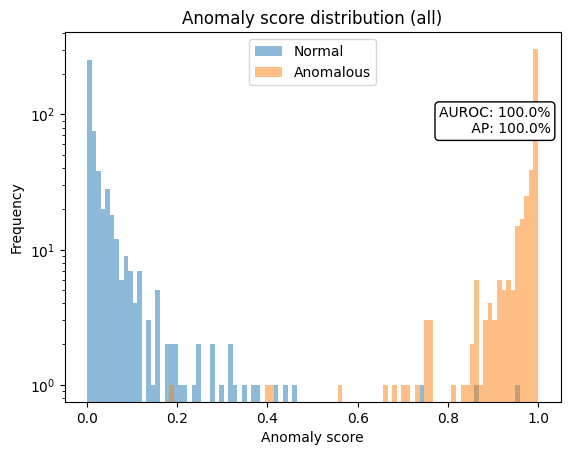

In [10]:
scripts.train_detector(
    supervised_task, detector, save_path=None, eval_batch_size=64, batch_size=64
)

# LCAs

In [11]:
class ElementwiseLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        shape = x.shape[:-1]
        assert x.ndim >= 3, shape
        assert x.shape[-1] == self.linear.in_features, (
            x.shape,
            self.linear.in_features,
        )
        out_shape = x.shape[:-1] + (self.linear.out_features,)
        return self.linear(x.view(-1, x.shape[-1])).view(*out_shape)

In [12]:
with bf.BlobFile("gs://arc-ml-public/distinctions/datasets/hex_task.json") as f:
    task_config = json.load(f)

# cpu to avoid MPS issues with tensors that are too large
effect_tokens = torch.tensor(
    task_config["effect_tokens"], dtype=torch.long, device="cpu"
)


class Quotient(nn.Module):
    def __init__(self, effect_tokens):
        super().__init__()
        self.effect_tokens_mask = torch.zeros(
            task.model.cfg.d_vocab, dtype=torch.bool, device=effect_tokens.device
        )
        self.effect_tokens_mask[effect_tokens] = True
        self.non_effect_tokens_mask = ~self.effect_tokens_mask

    def forward(self, logits):
        assert logits.ndim >= 2, logits.shape
        probs = torch.softmax(logits, dim=-1)
        return torch.stack(
            [
                probs[..., self.effect_tokens_mask].sum(dim=-1),
                probs[..., self.non_effect_tokens_mask].sum(dim=-1),
            ],
            dim=-1,
        )

In [13]:
config = deepcopy(task.model.cfg)
config.d_model = 64
config.d_head = 8
config.d_mlp = 256  # Kind of unnecessary since this is attn-only
config.d_vocab_out = 2  # We only want to predict whether the "effect token" comes next
abstract_model = HookedTransformer(config, task.model.tokenizer).mps()
abstract_model.init_weights()


def processing_func(activation, inputs, name):
    if name == "unembed.output":
        return get_activation_at_last_token(activation, inputs, name)
    else:
        return activation


tau_maps = {
    # "embed.output": ElementwiseLinear(512, 64),
    # "blocks.0.hook_attn_out.output": ElementwiseLinear(512, 64),
    # "ln_final.hook_normalized.output": ElementwiseLinear(512, 64),
    "unembed.output": Quotient(effect_tokens),
    # The cross entropy loss we use expects the tau map output to be probabilities
    # rather than unnormalized logits:
    # "unembed.output": nn.Softmax(dim=-1),
}
# Default for the others will be L2
loss_fns = {
    "unembed.output": detectors.abstraction.cross_entropy,
}
abstraction = detectors.abstraction.LocallyConsistentAbstraction(
    tau_maps,
    abstract_model,
    loss_fns=loss_fns,
    # activation_processing_func=processing_func,
    global_consistency=True,
)

Moving model to device:  mps


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /Users/erik/code/cupbearer/notebooks/lightning_logs

  | Name        | Type                         | Params
-------------------------------------------------------------
0 | abstraction | LocallyConsistentAbstraction | 3.2 M 
1 | model       | HookedTransformer            | 51.0 M
-------------------------------------------------------------
3.2 M     Trainable params
51.0 M    Non-trainable params
54.2 M    Total params
216.867   Total estimated model params size (MB)


Moving model to device:  mps


/Users/erik/.pyenv/versions/3.10.9/envs/cupbearer/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

2024-05-25 22:25:31.870 | INFO     | cupbearer.detectors.anomaly_detector:eval:152 - AUC_ROC (all): 0.4891
2024-05-25 22:25:31.871 | INFO     | cupbearer.detectors.anomaly_detector:eval:153 - AP (all): 0.5498


(defaultdict(dict,
             {'all': {'AUC_ROC': 0.4891061782836914,
               'AP': 0.5497563218474965}}),
 {'all': <Figure size 640x480 with 1 Axes>})

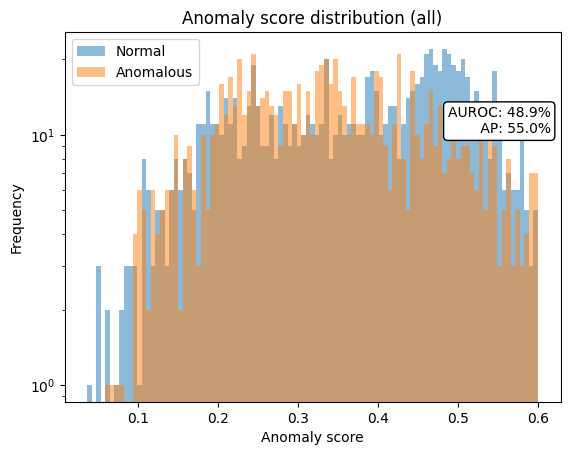

In [14]:
detector = detectors.AbstractionDetector(
    abstraction,
    # activation_processing_func=processing_func,
)
task.model.to("mps")
scripts.train_detector(
    task,
    detector,
    save_path=None,
    eval_batch_size=64,
    batch_size=64,
    max_epochs=5,
    accelerator="mps",
)